In [10]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import torch.nn as nn
import torchvision.models as models
import os
from PIL import Image
from IPython.display import display, clear_output
import time

In [2]:
yolo = YOLO("yolov8n.pt")

In [3]:
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features)[:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )
        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

csrnet = CSRNet().to(device)
ckpt = torch.load("finetuned_epoch_29.pth", map_location=device)
csrnet.load_state_dict(ckpt["model"])
csrnet.eval()


d:\Python Projects\DeepVision\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python Projects\DeepVision\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [5]:
def preprocess(img):
    img = cv2.resize(img, (1024, 768))
    img = img / 255.0
    img = img.transpose(2, 0, 1)
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)
    return img


In [6]:
def hybrid_count(frame):
    results = yolo(frame, verbose=False)[0]

    total_people = 0
    out_frame = frame.copy()

    for box in results.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])

        if cls == 0 and conf > 0.5:   # PERSON
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = frame[y1:y2, x1:x2]

            if crop.size == 0:
                continue

            inp = preprocess(crop)
            with torch.no_grad():
                density = csrnet(inp).cpu().numpy()[0, 0]

            # 🔥 IMPORTANT FIX
            person_count = max(1, density.sum() * 0.15)

            total_people += person_count

            cv2.rectangle(out_frame, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(out_frame, f"{person_count:.1f}",
                        (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0,255,0), 2)

    alert = "SAFE"
    color = (0,255,0)
    if total_people > 20:
        alert = "⚠️ CROWD ALERT"
        color = (0,0,255)

    cv2.putText(out_frame,
                f"Count: {total_people:.1f} | {alert}",
                (20,40), cv2.FONT_HERSHEY_SIMPLEX,
                1.1, color, 3)

    return out_frame, total_people, alert


In [7]:
video_path = "test1.mp4"   # your downloaded MP4
output_path = "video/output_processed.mp4"

cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))


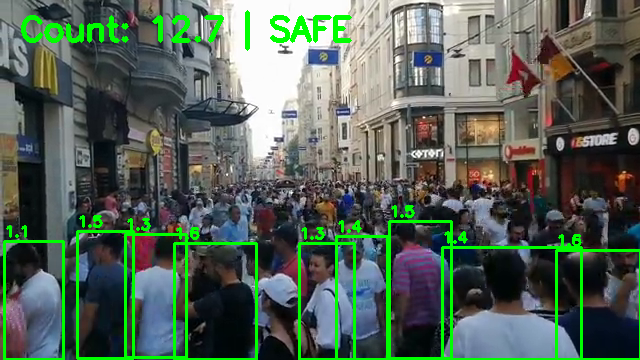

🎞 Frame: 40/275
📊 Progress: 14.5%
👥 Count: 12.7 | SAFE
⏳ Elapsed: 4666.4s
⏱ ETA: 27415.0s


In [ ]:
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

frame_id = 0
start_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    processed, count, alert = hybrid_count(frame)
    out.write(processed)

    frame_id += 1

    # Show progress every 10 frames
    if frame_id % 10 == 0:
        elapsed = time.time() - start_time
        avg_time = elapsed / frame_id
        remaining = (total_frames - frame_id) * avg_time

        progress = (frame_id / total_frames) * 100

        rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        display(Image.fromarray(rgb))

        print(f"🎞 Frame: {frame_id}/{total_frames}")
        print(f"📊 Progress: {progress:.1f}%")
        print(f"👥 Count: {count:.1f} | {alert}")
        print(f"⏳ Elapsed: {elapsed:.1f}s")
        print(f"⏱ ETA: {remaining:.1f}s")

cap.release()
out.release()

print("✅ Video processing complete")
print("📁 Output saved as:", output_path)
